In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-sntjeorj
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-sntjeorj
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 23.64 MiB/s, done.
Updating files: 100% (12939/12939), done.


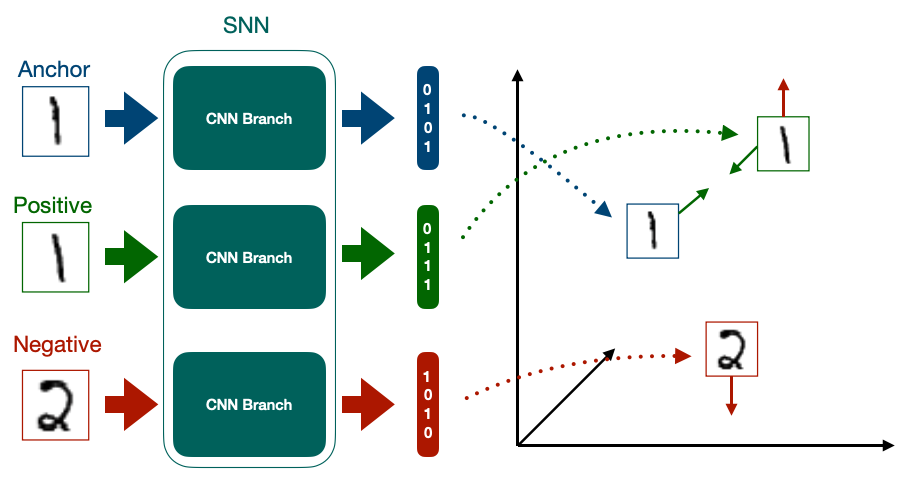

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Configurations

In [ ]:
DATA_DIR= '/content/Person-Re-Id-Dataset/train/'
CSV_FILE='/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE =32
LR=0.001
EPOCHS=15

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]
A_img=io.imread(DATA_DIR+ row.Anchor)
P_img=io.imread(DATA_DIR+ row.Positive)
N_img=io.imread(DATA_DIR+ row.Negative)

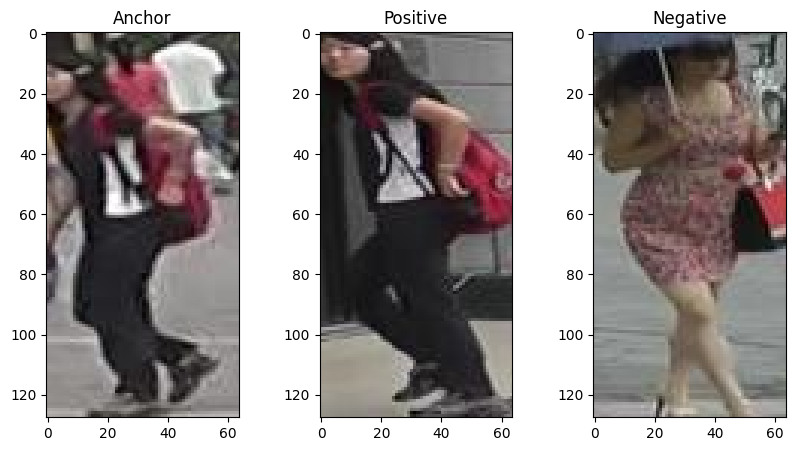

In [ ]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)


ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img

In [ ]:
trainset=APN_Dataset(train_df)
validset=APN_Dataset(valid_df)
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


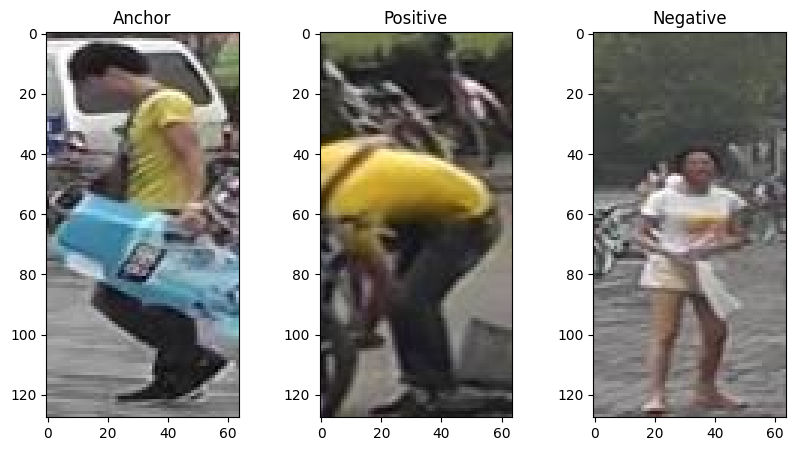

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
from numpy.random import shuffle
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A,P,N in trainloader:
  break;
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()   # <-- FIX

        self.efficientnet = timm.create_model(
            'efficientnet_b0', pretrained=True
        )
        self.efficientnet.classifier = nn.Linear(
            in_features=self.efficientnet.classifier.in_features,
            out_features=emb_size
        )

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings


In [ ]:
model=APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [ ]:
def train_fn(model , dataloader , optimzer, criterion):
  model.train()
  total_loss = 0.0
  for A,P,N in tqdm(dataloader):
    A = A.to(DEVICE)
    P = P.to(DEVICE)
    N = N.to(DEVICE)
    A_embs=model(A)
    P_embs=model(P)
    N_embs=model(N)
    loss=criterion(A_embs,P_embs,N_embs)
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
    total_loss+=loss.item()
  return total_loss/len(dataloader)


In [ ]:
def eval_fn(model , dataloader , criterion):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
        A = A.to(DEVICE)
        P = P.to(DEVICE)
        N = N.to(DEVICE)
        A_embs=model(A)
        P_embs=model(P)
        N_embs=model(N)
        loss=criterion(A_embs,P_embs,N_embs)
        total_loss+=loss.item()
    return total_loss/len(dataloader)


In [ ]:
criterion=nn.TripletMarginLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

# Create Training Loop

In [ ]:
best_valid_loss=float('inf')
for i in range(EPOCHS):
  train_loss=train_fn(model,trainloader,optimizer,criterion)
  valid_loss=eval_fn(model,validloader,criterion)
  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    best_valid_loss=valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  9.18it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 1
Train Loss : 0.6329932788014412
Valid Loss : 0.7081919467449188


100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 2
Train Loss : 0.2946004281193018
Valid Loss : 0.330721675157547


100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 3
Train Loss : 0.17349185854196547
Valid Loss : 0.2732377779483795


100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 4
Train Loss : 0.11103875428438187
Valid Loss : 0.22737697541713714


100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


Epoch : 5
Train Loss : 0.07673851579427719
Valid Loss : 0.26116020143032076


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch : 6
Train Loss : 0.06182829074561596
Valid Loss : 0.29739036679267883


100%|██████████| 25/25 [00:05<00:00,  4.88it/s]


Epoch : 7
Train Loss : 0.04669482320547104
Valid Loss : 0.2998466449975967


100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 8
Train Loss : 0.06808404974639416
Valid Loss : 0.18850795477628707


100%|██████████| 25/25 [00:02<00:00,  8.56it/s]


Epoch : 9
Train Loss : 0.06934693075716496
Valid Loss : 0.1991885358095169


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 10
Train Loss : 0.061278812885284424
Valid Loss : 0.1621408572793007


100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 11
Train Loss : 0.03476104408502579
Valid Loss : 0.15664257794618608


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 12
Train Loss : 0.033835363090038297
Valid Loss : 0.14374148100614548


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 13
Train Loss : 0.021970843821763994
Valid Loss : 0.12757095634937288


100%|██████████| 25/25 [00:03<00:00,  7.94it/s]


Epoch : 14
Train Loss : 0.01876192890107632
Valid Loss : 0.13753880679607391


100%|██████████| 25/25 [00:02<00:00,  9.04it/s]

SAVED_WEIGHTS_SUCCESS
Epoch : 15
Train Loss : 0.026231248527765275
Valid Loss : 0.12444728702306747


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            # read image
            A = io.imread(DATA_DIR + i)

            # HWC → CHW and normalize
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0

            # Add batch dimension and move to device
            A = A.unsqueeze(0).to(DEVICE)

            # forward pass
            A_enc = model(A)

            encodings.append(A_enc.cpu().detach().numpy())

        encodings = np.concatenate(encodings, axis=0)
        encodings_df = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names.reset_index(drop=True), encodings_df], axis=1)
    return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc=get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:46<00:00, 86.87it/s] 


In [ ]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.433068,-0.417198,0.891657,-0.479570,-0.943861,0.000187,-0.216023,0.368998,0.047618,...,-0.955040,-0.612401,-0.168479,0.199433,-0.187336,0.916800,-0.029874,0.511060,-0.426263,0.143781
1,1420_c3s3_061978_03.jpg,-0.237800,-0.030625,0.509942,-0.339689,-0.389239,0.315980,-0.217493,-0.416222,0.214701,...,-0.723782,-0.084592,0.260973,0.026506,-0.255894,0.712944,0.155362,0.631988,-0.282487,0.147431
2,1420_c5s3_062565_05.jpg,-0.386398,-0.015438,0.687276,-0.015700,-0.479229,-0.024638,-0.249298,-0.207444,-0.041210,...,-0.694953,-0.379951,0.065003,-0.124115,-0.109448,0.664954,0.154995,0.547677,-0.215656,0.183990
3,1420_c6s3_085592_04.jpg,-0.424829,0.163923,0.659325,0.317717,-0.689429,-0.296908,-0.044603,0.037190,0.080464,...,-0.013194,-0.549110,0.009633,0.016286,0.186625,0.640772,-0.070731,0.297028,-0.053371,0.280291
4,0663_c5s3_085987_03.jpg,-0.576618,-0.221585,-0.700736,0.216120,-0.562878,0.690942,-0.135244,0.088839,-0.559131,...,0.080835,0.298876,0.859995,-0.363429,0.946009,0.137409,0.556596,-1.315969,0.329824,-1.285984


# Inference

In [ ]:
def euclidean_distance(img_enc,anc_end_arr):
  dist=np.sqrt(np.sum((img_enc-anc_end_arr)**2,axis=1))
  return dist

In [ ]:
idx=0
img_name=df_enc['Anchor'].iloc[idx]
img_path=DATA_DIR+img_name
img=io.imread(img_path)
img=torch.from_numpy(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
  img=img.to(DEVICE)
  img_enc=model(img.unsqueeze(0))
  img_enc=img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr=df_enc.iloc[:,1:].to_numpy()
anc_img_names=df_enc['Anchor']

In [ ]:
distance=[]
for i in range (anc_enc_arr.shape[0]):
  dist=euclidean_distance(img_enc,anc_enc_arr[i:i+1,])
  distance.append(dist)

In [ ]:
closest_idx=np.argmin(distance)

/usr/local/lib/python3.12/dist-packages/networkx/drawing/layout.py:987: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


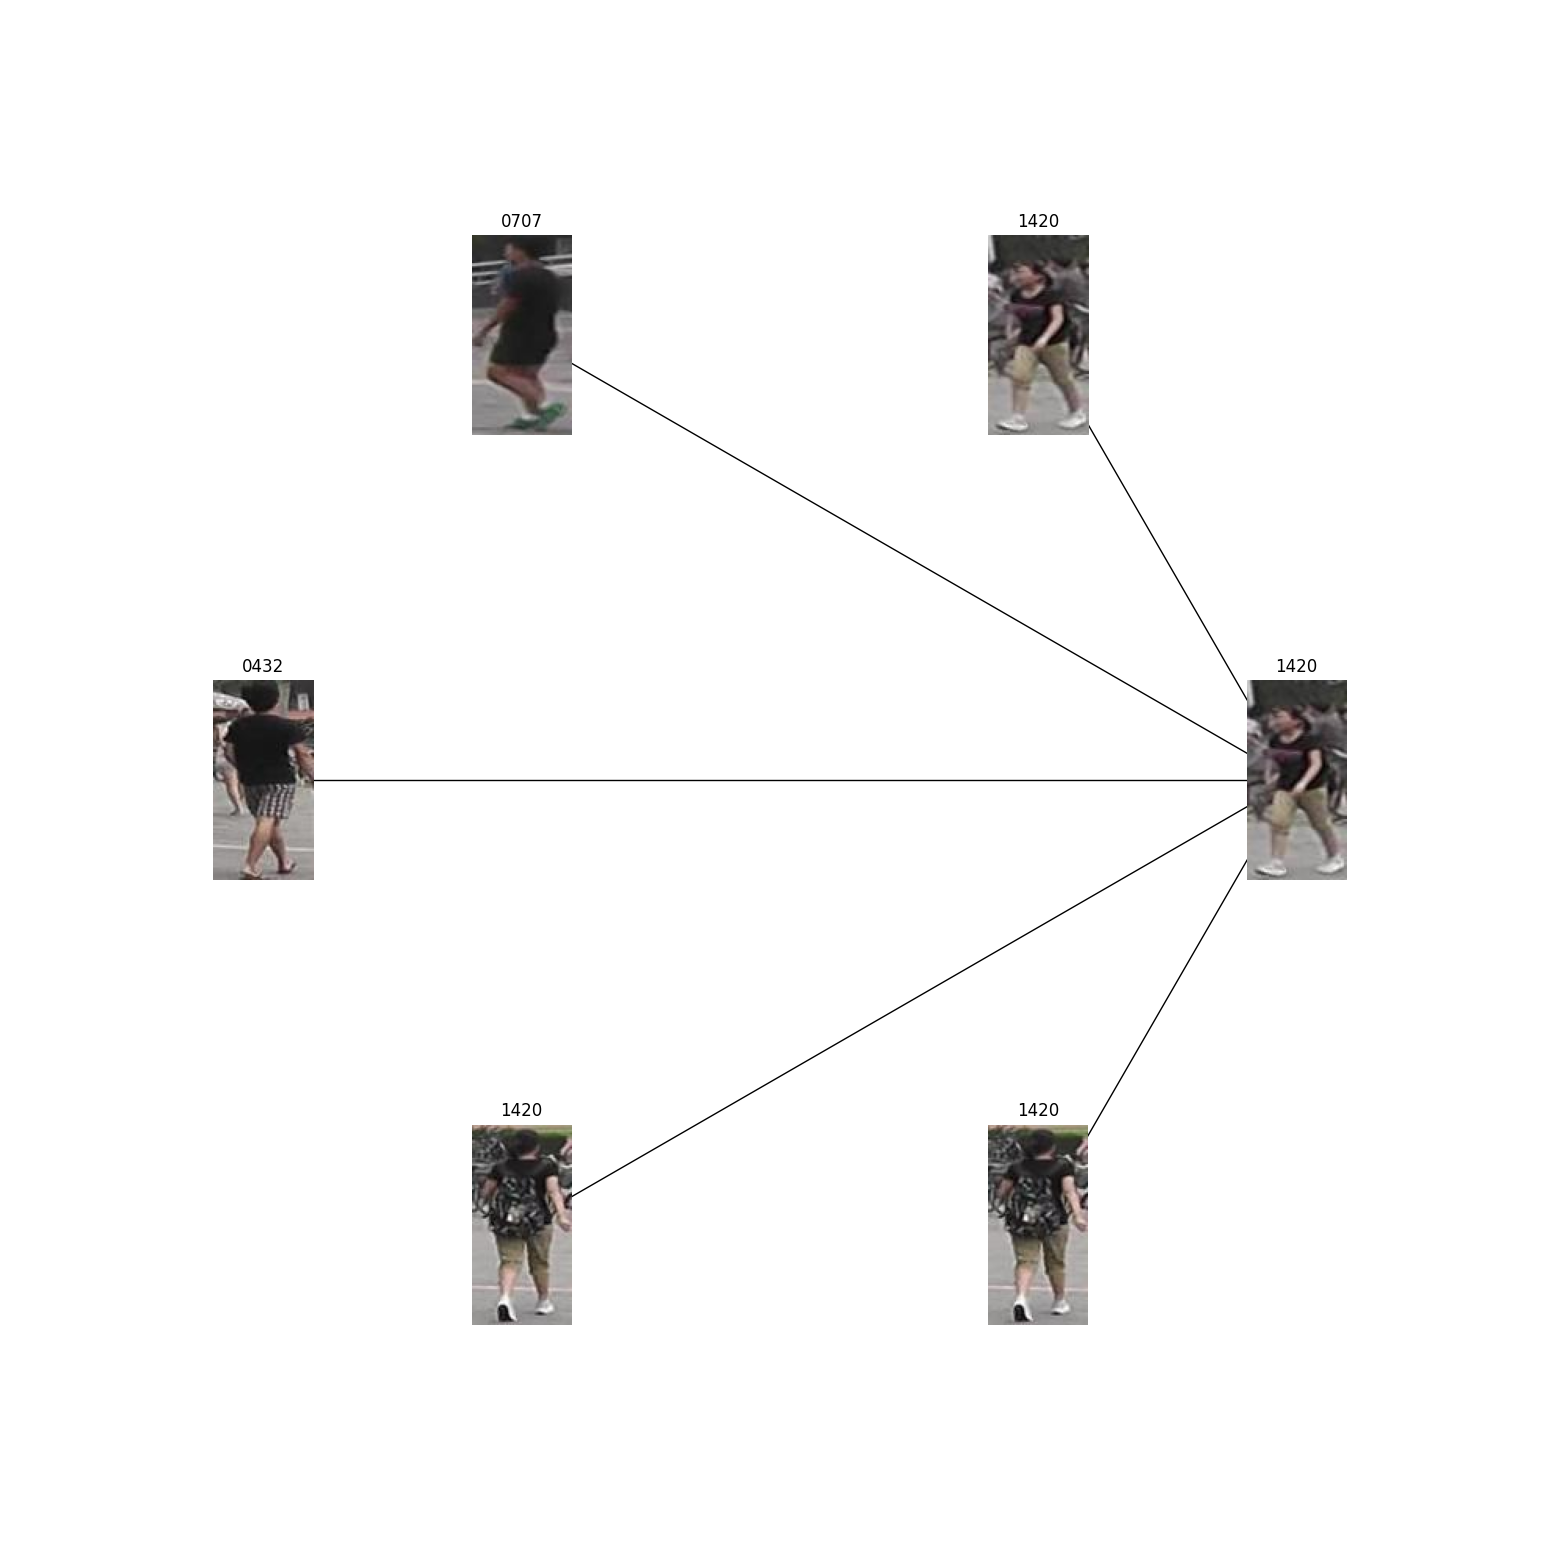

In [ ]:
import numpy as np
from utils import plot_closest_imgs

# Flatten the list of single-element arrays into a 1D array of distances
flat_distance = np.array([d[0] for d in distance])

# Get the indices that would sort the distances in ascending order
sorted_indices = np.argsort(flat_distance)

# Get the top 'no_of_closest' indices
no_of_closest = 5
closest_idx_corrected = sorted_indices[:no_of_closest]

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx_corrected, distance, no_of_closest = 5);